In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
import warnings
warnings.filterwarnings("ignore")
    
%matplotlib inline

# 匯入資料集

In [2]:
data = pd.read_excel('C:/Users/Administrator/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data['highest_school_level'] = data['highest_school_level'].astype('int')
data = data.drop(['interview','second_interview','relabel'], axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,bmi,bmi_cagegory
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,0,23,1
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,0,21,1
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,0,26,0
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,0,18,0
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,0,19,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 18 columns):
id                      1188 non-null object
sex                     1188 non-null object
apply_age               1188 non-null int64
marriage                1188 non-null int64
highest_education       1188 non-null object
highest_graduation      1188 non-null object
loan                    1188 non-null int64
loan_status             1188 non-null int64
military_status         1188 non-null int64
aboriginal              1188 non-null int64
height                  1188 non-null int64
weight                  1188 non-null int64
nationality             1188 non-null int64
highest_school_level    1188 non-null int32
english_level           1188 non-null float64
hired_or_not            1188 non-null int64
bmi                     1188 non-null int64
bmi_cagegory            1188 non-null int64
dtypes: float64(1), int32(1), int64(12), object(4)
memory usage: 171.7+ KB


# 檢視資料集

,sex,hired_or_not
0,F,0.081
1,M,0.095


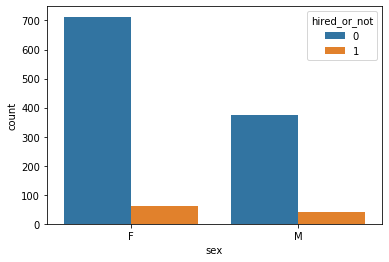

In [4]:
# 性別
sns.countplot(data['sex'], hue=data['hired_or_not'])
display(data[['sex','hired_or_not']].groupby(['sex'], as_index=False).mean().round(3))

,highest_education,hired_or_not
0,B,0.085
1,D,0.000
2,M,0.093


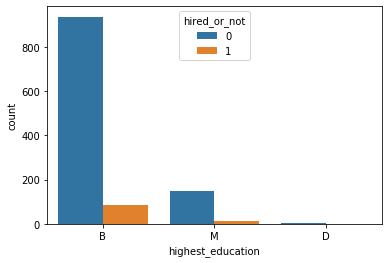

In [5]:
# 最高學歷
sns.countplot(data['highest_education'], hue=data['hired_or_not'])
display(data[['highest_education','hired_or_not']].groupby(['highest_education'], as_index=False).mean().round(3))

,loan,hired_or_not
0,0,0.081
1,1,0.101


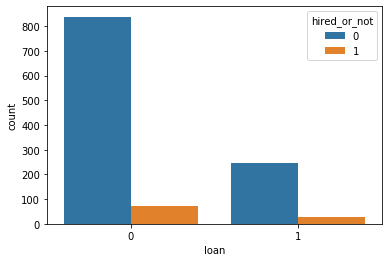

In [6]:
# 借貸狀況
sns.countplot(data['loan'], hue=data['hired_or_not'])
display(data[['loan','hired_or_not']].groupby(['loan'], as_index=False).mean().round(3))

,marriage,hired_or_not
0,0,0.089
1,1,0.063


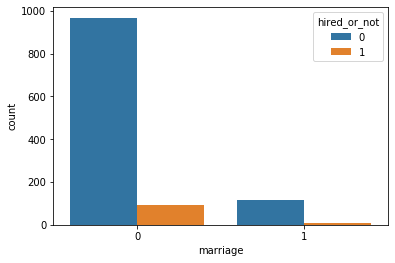

In [7]:
# 婚姻狀況
sns.countplot(data['marriage'], hue=data['hired_or_not'])
display(data[['marriage','hired_or_not']].groupby(['marriage'], as_index=False).mean().round(3))

,bmi_cagegory,hired_or_not
0,0,0.088
1,1,0.085


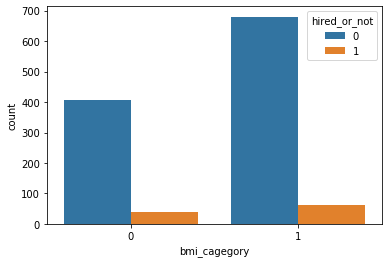

In [8]:
# BMI
sns.countplot(data['bmi_cagegory'], hue=data['hired_or_not'])
display(data[['bmi_cagegory','hired_or_not']].groupby(['bmi_cagegory'], as_index=False).mean().round(3))

In [9]:
mask1 = data['sex'] == 'F'
mask2 = data['hired_or_not'] == 1
mask3 = data['sex'] == 'M'
mask4 = data['hired_or_not'] == 1

print("女性應徵錄取率：", len(data[(mask1 & mask2)]) / len(data[data['sex']=='F']))
print("男性應徵錄取率：", len(data[(mask3 & mask4)]) / len(data[data['sex']=='M']))
print("應徵者女男比：", len(data[data['sex']=='F'])/ len(data[data['sex']=='M']))
print("錄取者女男比：", len(data[(mask1 & mask2)]) / len(data[(mask3 & mask4)]))

女性應徵錄取率： 0.08118556701030928
男性應徵錄取率： 0.09466019417475728
應徵者女男比： 1.883495145631068
錄取者女男比： 1.6153846153846154


In [10]:
print("女性應徵者平均年齡：", data[data['sex']=='F'].apply_age.mean())
print("女性應徵者平均錄取年齡：", data[(mask1 & mask2)].apply_age.mean())
print("男性應徵者平均年齡：", data[data['sex']=='M'].apply_age.mean())
print("男性應徵者平均錄取年齡：", data[(mask3 & mask4)].apply_age.mean())

女性應徵者平均年齡： 26.41623711340206
女性應徵者平均錄取年齡： 25.26984126984127
男性應徵者平均年齡： 27.315533980582526
男性應徵者平均錄取年齡： 26.53846153846154


# 進行訓練

In [11]:
data_train = data.iloc[:,1:-3]
data_hired = data.iloc[:,-3]
data_train = pd.get_dummies(data_train)

In [12]:
data_train.head()

,apply_age,marriage,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,sex_F,sex_M,highest_education_B,highest_education_D,highest_education_M,highest_graduation_D,highest_graduation_I,highest_graduation_Y
0,24,0,0,1,1,0,162,60,1,3,2.0,1,0,1,0,0,0,0,1
1,28,0,1,1,1,0,158,52,1,2,2.0,1,0,1,0,0,0,0,1
2,24,0,1,1,1,0,164,70,1,3,2.0,1,0,1,0,0,0,0,1
3,21,0,0,1,1,0,152,41,1,5,2.0,1,0,1,0,0,0,0,1
4,22,0,0,1,1,0,155,45,1,6,3.0,1,0,1,0,0,0,1,0


In [13]:
data_hired.head()

0    0
1    0
2    0
3    0
4    0
Name: hired_or_not, dtype: int64

In [14]:
df_train, df_test, hired_train, hired_test = train_test_split(data_train, data_hired, test_size = 0.2, random_state = 0)

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_train_logistic = sc.fit_transform(df_train)
df_test_logistic = sc.transform(df_test)

In [16]:
logistic_reg = LogisticRegression()

In [17]:
# 進行訓練
logistic_reg.fit(df_train_logistic, hired_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# 預測
logistic_pred = logistic_reg.predict(df_test_logistic)

In [19]:
# 預測機率
logistic_pred_proba = logistic_reg.predict_proba(df_test_logistic)

In [20]:
# 準確率
accuracy_score(hired_test, logistic_pred)

0.9117647058823529

# 建立測試資料集

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

In [22]:
n_pop = 1000000
p_male = 0.7

p_job_male, p_job_female = 0.09, 0.05

In [23]:
gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])

df = pd.DataFrame({'gender' : gender})

df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])

df['found_job'] = df['found_job'].astype(int)

In [24]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,284995,15023
male,636697,63285


In [49]:
mu_job, sigma_job = 25, 8
mu_no_job, sigma_no_job = 35, 10

In [50]:
df.loc[df.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job, sigma_job, len(df.loc[df.found_job == 1])))
df.loc[df.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job, sigma_no_job, len(df.loc[df.found_job == 0])))

df['age'] = df['age'].astype(int)

In [51]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,34.5
1,24.5


In [28]:
class_set = ['A', 'B', 'C']
class_wt_job = [0.4, 0.4, 0.2]
class_wt_no_job = [0.2, 0.3, 0.5]

In [29]:
df.loc[df.found_job == 1, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 1]), p=class_wt_job)
df.loc[df.found_job == 0, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 0]), p=class_wt_no_job)

In [30]:
df.pivot_table(index='class', columns='found_job', aggfunc='size')

found_job,0,1
class,,
A,184175,31266
B,276702,31463
C,460815,15579


In [31]:
agg_gender = df[['gender', 'found_job']].groupby('gender').mean()
agg_gender.round(3)

,found_job
gender,
female,0.05
male,0.09


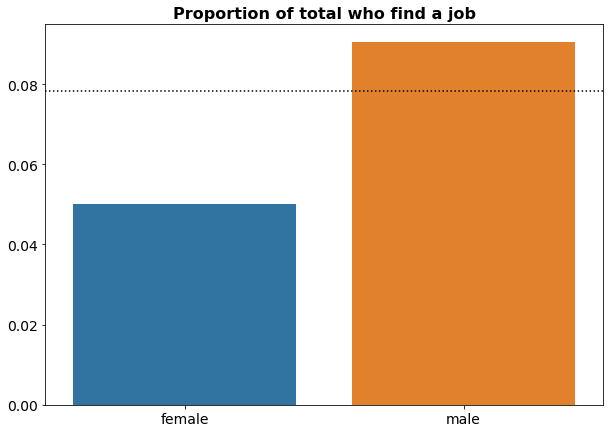

In [32]:
mean_found_job = df['found_job'].mean()

fig, ax1 = plt.subplots(figsize=(10, 7))
sns.barplot(x=agg_gender.index, y=agg_gender.found_job, ax=ax1).\
set_title('Proportion of total who find a job', fontsize=16, fontweight='bold')
ax1.axhline(mean_found_job, color='k', linestyle=':')
ax1.set(xlabel='', ylabel='')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

In [55]:
df.to_excel("df.xlsx")

Text(0.5, 1.0, 'Age vs Found or not')

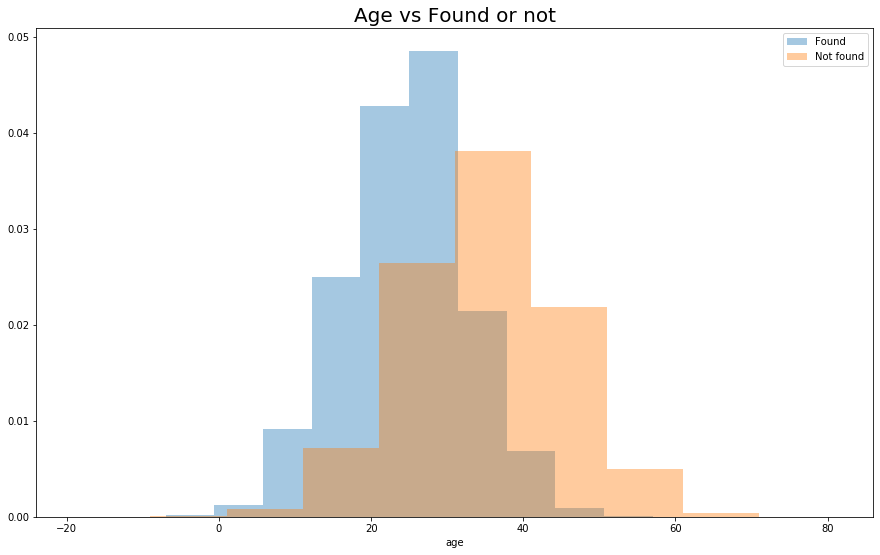

In [53]:
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df.loc[df['found_job']==1,'age'], kde=False, bins=10, norm_hist=True, label='Found') 
ax = sns.distplot(df.loc[df['found_job']==0,'age'], kde=False, bins=10, norm_hist=True, label='Not found')
ax.legend()
ax.set_title('Age vs Found or not',fontsize = 20)

,gender,found_job
0,female,0.05
1,male,0.09


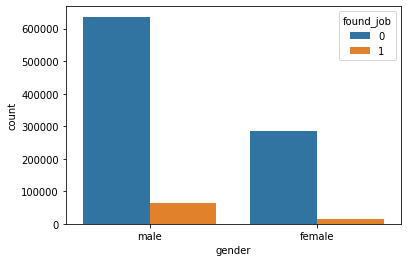

In [41]:
# 性別
sns.countplot(df['gender'], hue=df['found_job'])
display(df[['gender','found_job']].groupby(['gender'], as_index=False).mean().round(3))

In [54]:
df.groupby(['age','gender']).count()

found_job  class
age gender                  
-19 female          1      1
-16 male            1      1
-13 male            1      1
-11 female          1      1
-10 female          2      2
...               ...    ...
 77 male            8      8
 78 female          1      1
    male            2      2
 79 male            1      1
 81 male            1      1

[183 rows x 2 columns]

# 採樣並建立測試資料集

In [162]:
data = pd.read_excel('C:/Users/Administrator/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data = data.drop(['interview','second_interview','relabel'], axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,relabel_check
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,N,N
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,N,N
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,N,N
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,N,N
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,N,N


In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 17 columns):
id                      1188 non-null object
sex                     1188 non-null object
apply_age               1188 non-null int64
marriage                1188 non-null int64
highest_education       1188 non-null object
highest_graduation      1188 non-null object
loan                    1188 non-null int64
loan_status             1188 non-null int64
military_status         1188 non-null int64
aboriginal              1188 non-null int64
height                  1188 non-null int64
weight                  1188 non-null int64
nationality             1188 non-null int64
highest_school_level    1188 non-null object
english_level           1188 non-null float64
hired_or_not            1188 non-null object
relabel_check           1188 non-null object
dtypes: float64(1), int64(9), object(7)
memory usage: 167.1+ KB


In [164]:
print("應徵總人數", len(data))
print("男性應徵人數", len(data[data['sex']=='M']))
print("男性錄取人數", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')]))
print("男性錄取率", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='M']))
print("女性應徵人數", len(data[data['sex']=='F']))
print("女性錄取人數", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')]))
print("女性錄取率", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='F']))
print("男性應徵人數占比",len(data[data['sex']=='M'])/len(data))
print("女性應徵人數占比",len(data[data['sex']=='F'])/len(data))

應徵總人數 1188
男性應徵人數 412
男性錄取人數 39
男性錄取率 0.09466019417475728
女性應徵人數 776
女性錄取人數 63
女性錄取率 0.08118556701030928
男性應徵人數占比 0.3468013468013468
女性應徵人數占比 0.6531986531986532


In [165]:
# 設定資料集男女比及應徵錄取比
n_pop = 1000000
p_male = 0.3468
p_job_male, p_job_female = 0.0946, 0.0812

gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])
df = pd.DataFrame({'gender' : gender})
df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])
df['found_job'] = df['found_job'].astype(int)

In [166]:
# 檢視資料集
print("男性應徵人數", len(df[df['gender']=='male']))
print("男性錄取人數", len(df[(df['gender']=='male') & (df['found_job']==1)]))
print("男性錄取率", len(df[(df['gender']=='male') & (df['found_job']==1)])/len(df[df['gender']=='male']))
print("女性應徵人數", len(df[df['gender']=='female']))
print("女性錄取人數", len(df[(df['gender']=='female') & (df['found_job']==1)]))
print("女性錄取率", len(df[(df['gender']=='female') & (df['found_job']==1)])/len(df[df['gender']=='female']))
print("男性應徵人數占比",len(df[df['gender']=='male'])/len(df))
print("女性應徵人數占比",len(df[df['gender']=='female'])/len(df))

男性應徵人數 346745
男性錄取人數 33095
男性錄取率 0.09544477930467635
女性應徵人數 653255
女性錄取人數 53065
女性錄取率 0.08123167828795799
男性應徵人數占比 0.346745
女性應徵人數占比 0.653255


In [167]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,600190,53065
male,313650,33095


In [168]:
print("男性錄取年齡平均", data[(data['sex']=='M') & (data['hired_or_not']=='Y')].apply_age.mean())
print("男性錄取年齡標準差", data[(data['sex']=='M') & (data['hired_or_not']=='Y')].apply_age.std())
print("男性未錄取年齡平均", data[(data['sex']=='M') & (data['hired_or_not']=='N')].apply_age.mean())
print("男性未錄取年齡標準差", data[(data['sex']=='M') & (data['hired_or_not']=='N')].apply_age.std())
print("---------------------------------------------------------------------")
print("女性錄取年齡平均", data[(data['sex']=='F') & (data['hired_or_not']=='Y')].apply_age.mean())
print("女性錄取年齡標準差", data[(data['sex']=='F') & (data['hired_or_not']=='Y')].apply_age.std())
print("女性未錄取年齡平均", data[(data['sex']=='F') & (data['hired_or_not']=='N')].apply_age.mean())
print("女性未錄取年齡標準差", data[(data['sex']=='F') & (data['hired_or_not']=='N')].apply_age.std())

男性錄取年齡平均 26.53846153846154
男性錄取年齡標準差 3.3938501180048863
男性未錄取年齡平均 27.396782841823057
男性未錄取年齡標準差 4.783842693106973
---------------------------------------------------------------------
女性錄取年齡平均 25.26984126984127
女性錄取年齡標準差 2.806710560059008
女性未錄取年齡平均 26.517531556802243
女性未錄取年齡標準差 4.669111814273186


In [169]:
# 設定資料集年齡分布(待採樣)
mu_job_male, sigma_job_male = 26.5385, 3.3939
mu_no_job_male, sigma_no_job_male = 27.3968, 4.7838

mu_job_female, sigma_job_female = 25.2698, 2.8067
mu_no_job_female, sigma_no_job_female = 26.5175, 4.6691

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job_male, sigma_job_male, len(df_male.loc[df_male.found_job == 1])))
df_male.loc[df_male.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job_male, sigma_no_job_male, len(df_male.loc[df_male.found_job == 0])))
df_female.loc[df_female.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job_female, sigma_job_female, len(df_female.loc[df_female.found_job == 1])))
df_female.loc[df_female.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job_female, sigma_no_job_female, len(df_female.loc[df_female.found_job == 0])))

df = df_male.append(df_female)
df['age'] = df['age'].astype(int)

In [170]:
print("男性錄取年齡平均", df[(df['gender']=='male') & (df['found_job']==1)].age.mean())
print("男性錄取年齡標準差", df[(df['gender']=='male') & (df['found_job']==1)].age.std())
print("男性未錄取年齡平均", df[(df['gender']=='male') & (df['found_job']==0)].age.mean())
print("男性未錄取年齡標準差", df[(df['gender']=='male') & (df['found_job']==0)].age.std())
print("---------------------------------------------------------------------")
print("女性錄取年齡平均", df[(df['gender']=='female') & (df['found_job']==1)].age.mean())
print("女性錄取年齡標準差", df[(df['gender']=='female') & (df['found_job']==1)].age.std())
print("女性未錄取年齡平均", df[(df['gender']=='female') & (df['found_job']==0)].age.mean())
print("女性未錄取年齡標準差", df[(df['gender']=='female') & (df['found_job']==0)].age.std())

男性錄取年齡平均 26.00676839401722
男性錄取年齡標準差 3.391759643128539
男性未錄取年齡平均 26.897631117487645
男性未錄取年齡標準差 4.78264371429016
---------------------------------------------------------------------
女性錄取年齡平均 24.7745783473099
女性錄取年齡標準差 2.8316817032423542
女性未錄取年齡平均 26.024530565320983
女性未錄取年齡標準差 4.68005487606021


In [171]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,26.3
1,25.2


In [172]:
# 設定資料集學歷分布(待採樣)
print("學士人數", len(data[data['highest_education']=='B']))
print("碩士人數", len(data[data['highest_education']=='M']))
print("博士人數", len(data[data['highest_education']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')]))
print("碩士錄取人數", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')]))
print("博士錄取人數", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')]))
print("總錄取人數", len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("碩士錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("博士錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("碩士不錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("博士不錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

學士人數 1024
碩士人數 162
博士人數 2
---------------------------------------------------------------------
學士錄取人數 87
碩士錄取人數 15
博士錄取人數 0
總錄取人數 102
---------------------------------------------------------------------
學士錄取率 0.8529411764705882
碩士錄取率 0.14705882352941177
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8627992633517495
碩士不錄取率 0.13535911602209943
博士不錄取率 0.001841620626151013


In [173]:
educ_class_set = ['B', 'M', 'D']
educ_class_wt_job = [0.8529, 0.1471, 0]
educ_class_wt_no_job = [0.8628, 0.1354, 0.0018]

df.loc[df.found_job == 1, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 1]), p=educ_class_wt_job)
df.loc[df.found_job == 0, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 0]), p=educ_class_wt_no_job)

In [174]:
# 檢視資料集學歷分布
print("學士人數", len(df[df['educ_class']=='B']))
print("碩士人數", len(df[df['educ_class']=='M']))
print("博士人數", len(df[df['educ_class']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(df[(df['educ_class']=='B') & (df['found_job']==1)]))
print("碩士錄取人數", len(df[(df['educ_class']=='M') & (df['found_job']==1)]))
print("博士錄取人數", len(df[(df['educ_class']=='D') & (df['found_job']==1)]))
print("總錄取人數", len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("碩士錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("博士錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("碩士不錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("博士不錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==0)])/len(df[df['found_job']==0]))

學士人數 861793
碩士人數 136630
博士人數 1577
---------------------------------------------------------------------
學士錄取人數 73530
碩士錄取人數 12630
博士錄取人數 0
總錄取人數 86160
---------------------------------------------------------------------
學士錄取率 0.8534122562674095
碩士錄取率 0.14658774373259054
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8625831655432024
碩士不錄取率 0.13569114943534974
博士不錄取率 0.0017256850214479558


In [260]:
# 設定婚姻狀況資料分布(待採樣)
print("女性應徵總人數", len(data[data['sex']=='F']))
print("女性已婚總人數", len(data[(data['sex']=='F')&(data['marriage']==1)]))
print("女性未婚總人數", len(data[(data['sex']=='F')&(data['marriage']==0)]))
print("已錄取女性已婚人數", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')]))
print("女性錄取者已婚比例", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['hired_or_not']=='Y')]))
print("未錄取女性已婚人數", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='N')]))
print("女性未錄取者已婚比例", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='F')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("男性應徵總人數", len(data[data['sex']=='M']))
print("男性已婚總人數", len(data[(data['sex']=='M')&(data['marriage']==1)]))
print("男性未婚總人數", len(data[(data['sex']=='M')&(data['marriage']==0)]))
print("已錄取男性已婚人數", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')]))
print("男性錄取者已婚比例", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("未錄取男性已婚人數", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='N')]))
print("男性未錄取者已婚比例", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("已婚女性錄取率", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['marriage']==1)]))
print("未婚女性錄取率", len(data[(data['sex']=='F')&(data['marriage']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['marriage']==0)]))
print("已婚男性錄取率", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['marriage']==1)]))
print("未婚男性錄取率", len(data[(data['sex']=='M')&(data['marriage']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['marriage']==0)]))

女性應徵總人數 776
女性已婚總人數 95
女性未婚總人數 681
已錄取女性已婚人數 3
女性錄取者已婚比例 0.047619047619047616
未錄取女性已婚人數 92
女性未錄取者已婚比例 0.12903225806451613
---------------------------------------------------------------------
男性應徵總人數 412
男性已婚總人數 31
男性未婚總人數 381
已錄取男性已婚人數 5
男性錄取者已婚比例 0.1282051282051282
未錄取男性已婚人數 26
男性未錄取者已婚比例 0.06970509383378017
---------------------------------------------------------------------
已婚女性錄取率 0.031578947368421054
未婚女性錄取率 0.0881057268722467
已婚男性錄取率 0.16129032258064516
未婚男性錄取率 0.08923884514435695


In [261]:
# 設定男女婚姻狀況分布
# 男性錄取者已婚比例, 男性未錄取者已婚比例
p_job_male_marriage, p_no_job_male_marriage = 0.12820512, 0.06970509
# 女性錄取者已婚比例, 女性未錄取者已婚比例
p_job_female_marriage, p_no_job_female_marriage = 0.04761904, 0.12903225

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'marriage'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 1]), p=[p_job_male_marriage, 1 - p_job_male_marriage])
df_male.loc[df_male.found_job == 0, 'marriage'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 0]), p=[p_no_job_male_marriage, 1 - p_no_job_male_marriage])
df_female.loc[df_female.found_job == 1, 'marriage'] = np.random.choice([1, 0], size=len(df_female.loc[df_female.found_job == 1]), p=[p_job_female_marriage, 1 - p_job_female_marriage])
df_female.loc[df_female.found_job == 0, 'marriage'] = np.random.choice([1, 0], size=len(df_female.loc[df_female.found_job == 0]), p=[p_no_job_female_marriage, 1 - p_no_job_female_marriage])

df = df_male.append(df_female)

In [250]:
len(df[(df['gender']=='male')&(df['marriage']==0)&(df['found_job']==1)])

69934

In [263]:
# 設定婚姻狀況資料分布
print("女性應徵總人數", len(df[df['gender']=='female']))
print("女性已婚總人數", len(df[(df['gender']=='female')&(df['marriage']==1)]))
print("女性未婚總人數", len(df[(df['gender']=='female')&(df['marriage']==0)]))
print("已錄取女性已婚人數", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==1)]))
print("女性錄取者已婚比例", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['found_job']==1)]))
print("未錄取女性已婚人數", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==0)]))
print("女性未錄取者已婚比例", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==0)])/len(df[(df['gender']=='female')&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("男性應徵總人數", len(df[df['gender']=='male']))
print("男性已婚總人數", len(df[(df['gender']=='male')&(df['marriage']==1)]))
print("男性未婚總人數", len(df[(df['gender']=='male')&(df['marriage']==0)]))
print("已錄取男性已婚人數", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==1)]))
print("男性錄取者已婚比例", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("未錄取男性已婚人數", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==0)]))
print("男性未錄取者已婚比例", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("已婚女性錄取率", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['marriage']==1)]))
print("未婚女性錄取率", len(df[(df['gender']=='female')&(df['marriage']==0)&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['marriage']==0)]))
print("已婚男性錄取率", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['marriage']==1)]))
print("未婚男性錄取率", len(df[(df['gender']=='male')&(df['marriage']==0)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['marriage']==0)]))

女性應徵總人數 653255
女性已婚總人數 79666
女性未婚總人數 573589
已錄取女性已婚人數 2497
女性錄取者已婚比例 0.047055497974182604
未錄取女性已婚人數 77169
女性未錄取者已婚比例 0.12857428480981023
---------------------------------------------------------------------
男性應徵總人數 346745
男性已婚總人數 26195
男性未婚總人數 320550
已錄取男性已婚人數 4303
男性錄取者已婚比例 0.13001964042906783
未錄取男性已婚人數 21892
男性未錄取者已婚比例 0.06979754503427388
---------------------------------------------------------------------
已婚女性錄取率 0.03134335852182864
未婚女性錄取率 0.08816068648457345
已婚男性錄取率 0.16426799007444168
未婚男性錄取率 0.08982062080798628


In [256]:
df_male.to_excel("df.xlsx")

In [178]:
len(df[(df['gender']=='female') & (df['found_job']==1)])/len(df[(df['gender']=='female')])

0.08123167828795799

In [199]:
# 設定婚姻狀況資料分布(待採樣)
print("女性人數", len(df[df['gender']=='female']))
print("女性已婚人數", len(df[(df['gender']=='female') & (df['marriage']==1)]))
print("女性已婚占比", len(df[(df['gender']=='female') & (df['marriage']==1)])/len(df[df['gender']=='female']))
print("女性未婚人數", len(df[(df['gender']=='female') & (df['marriage']==0)]))
print("女性已婚錄取人數", len(df[(df['gender']=='female') & (df['marriage']==1) & (df['found_job']==1)]))
print("女性未婚錄取人數", len(df[(df['gender']=='female') & (df['marriage']==0) & (df['found_job']==1)]))
print("女性已婚族群錄取率", len(df[(df['gender']=='female') & (df['marriage']==1) & (df['found_job']==1)])/len(df[(df['gender']=='female') & (df['marriage']==1)]))
print("女性未婚族群錄取率", len(df[(df['gender']=='female') & (df['marriage']==0) & (df['found_job']==1)])/len(df[(df['gender']=='female') & (df['marriage']==0)]))
print("---------------------------------------------------------------------")
print("男性人數", len(df[df['gender']=='male']))
print("男性已婚人數", len(df[(df['gender']=='male') & (df['marriage']==1)]))
print("男性已婚占比", len(df[(df['gender']=='male') & (df['marriage']==1)])/len(df[df['gender']=='male']))
print("男性未婚人數", len(df[(df['gender']=='male') & (df['marriage']==0)]))
print("男性已婚錄取人數", len(df[(df['gender']=='male') & (df['marriage']==1) & (df['found_job']==1)]))
print("男性未婚錄取人數", len(df[(df['gender']=='male') & (df['marriage']==0) & (df['found_job']==1)]))
print("男性已婚族群錄取率", len(df[(df['gender']=='male') & (df['marriage']==1) & (df['found_job']==1)])/len(df[(df['gender']=='male') & (df['marriage']==1)]))
print("男性未婚族群錄取率", len(df[(df['gender']=='male') & (df['marriage']==0) & (df['found_job']==1)])/len(df[(df['gender']=='male') & (df['marriage']==0)]))

女性人數 653184
女性已婚人數 79643
女性已婚占比 0.12193042083088379
女性未婚人數 573541
女性已婚錄取人數 6367
女性未婚錄取人數 46355
女性已婚族群錄取率 0.07994425122107404
女性未婚族群錄取率 0.08082246953574374
---------------------------------------------------------------------
男性人數 346816
男性已婚人數 25862
男性已婚占比 0.0745698007012364
男性未婚人數 320954
男性已婚錄取人數 2544
男性未婚錄取人數 30275
男性已婚族群錄取率 0.09836826231536618
男性未婚族群錄取率 0.09432815917545817


In [200]:
df.loc[df.gender == 'male', 'marriage']

0         0.0
3         0.0
5         0.0
11        0.0
12        0.0
         ... 
999984    0.0
999987    1.0
999988    0.0
999995    0.0
999996    0.0
Name: marriage, Length: 346816, dtype: float64

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

In [17]:
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind' : thresh_arr_best_ind, \
    'thresh_arr_best' : thresh_arr_best, \
    'best_bal_acc' : best_bal_acc, \
    'disp_imp_at_best_bal_acc' : disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

In [118]:
df = data
df['gender'] = data['sex'].replace("M","male").replace("F","female")
df['found_job'] = data['hired_or_not'].replace("Y",1).replace("N",0)
df['height_2'] = df['height']*df['height']
df['height_2'] = df['height_2'] / 10000
df['bmi'] = df['weight']/df['height_2']
df['bmi'] = df['bmi'].round(1)
df['age'] = df['apply_age']
df = df.drop(['id','relabel_check','sex','hired_or_not','weight','height','height_2','apply_age'], axis=1)

In [119]:
df.head()

,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,nationality,highest_school_level,english_level,gender,found_job,bmi,age
0,N,B,Y,0,1,1,0,1,3,2.0,female,0,22.9,24
1,N,B,Y,1,1,1,0,1,2,2.0,female,0,20.8,28
2,N,B,Y,1,1,1,0,1,3,2.0,female,0,26.0,24
3,N,B,Y,0,1,1,0,1,5,2.0,female,0,17.7,21
4,N,B,I,0,1,1,0,1,6,3.0,female,0,18.7,22


# Convert to AIF360 format

In [120]:
df_onehot = pd.concat([df[['found_job', 'age', 'loan', 'loan_status', 'military_status', 'aboriginal', 'nationality', 'english_level', 'bmi', 'marriage']], 
                        pd.get_dummies(df[['gender', 'highest_education', 'highest_graduation', 'highest_school_level']])], axis=1)
df_onehot.head()

,found_job,age,loan,loan_status,military_status,aboriginal,nationality,english_level,bmi,marriage,...,highest_graduation_D,highest_graduation_I,highest_graduation_Y,highest_school_level_1,highest_school_level_2,highest_school_level_3,highest_school_level_4,highest_school_level_5,highest_school_level_6,highest_school_level_7
0,0,24,0,1,1,0,1,2.0,22.9,N,...,0,0,1,0,0,1,0,0,0,0
1,0,28,1,1,1,0,1,2.0,20.8,N,...,0,0,1,0,1,0,0,0,0,0
2,0,24,1,1,1,0,1,2.0,26.0,N,...,0,0,1,0,0,1,0,0,0,0
3,0,21,0,1,1,0,1,2.0,17.7,N,...,0,0,1,0,0,0,0,1,0,0
4,0,22,0,1,1,0,1,3.0,18.7,N,...,0,1,0,0,0,0,0,0,1,0


In [121]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 25 columns):
found_job                 1188 non-null int64
age                       1188 non-null int64
loan                      1188 non-null int64
loan_status               1188 non-null int64
military_status           1188 non-null int64
aboriginal                1188 non-null int64
nationality               1188 non-null int64
english_level             1188 non-null float64
bmi                       1188 non-null float64
marriage                  1188 non-null object
gender_female             1188 non-null uint8
gender_male               1188 non-null uint8
highest_education_B       1188 non-null uint8
highest_education_D       1188 non-null uint8
highest_education_M       1188 non-null uint8
highest_graduation_D      1188 non-null uint8
highest_graduation_I      1188 non-null uint8
highest_graduation_Y      1188 non-null uint8
highest_school_level_1    1188 non-null uint8
highest_school

In [98]:
df_aif = BinaryLabelDataset(df=df_onehot.drop('gender_male', axis=1), label_names=['found_job'], protected_attribute_names=['gender_female'])

In [99]:
privileged_group = [{'gender_female': 0}]
unprivileged_group = [{'gender_female': 1}]

In [100]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(594, 24), (356, 24), (238, 24)]


# Original dataset

In [101]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.244


# Train model on original dataset

In [102]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

# Find cutoff threshold using original validation dataset

In [103]:
thresh_arr = np.linspace(0.01, 0.5, 100)

In [104]:
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)

In [105]:
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

100%|██████████| 100/100 [00:00<00:00, 1431.80it/s]


In [106]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.059
Best balanced accuracy: 0.583
1-min(DI, 1/DI): 0.1


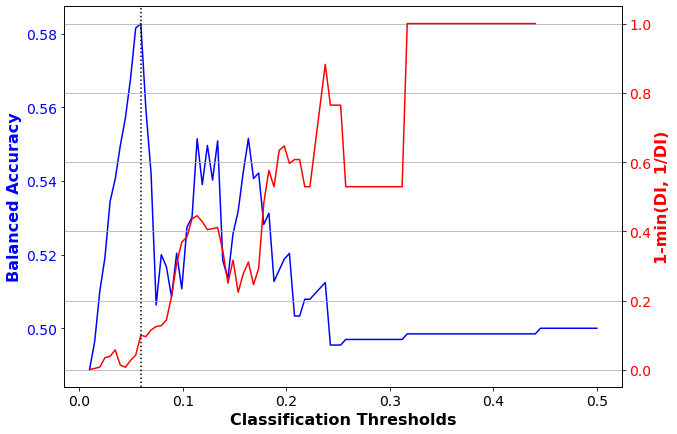

In [107]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on original dataset

In [108]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)

dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

In [109]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.059
Best balanced accuracy: 0.647
1-min(DI, 1/DI): 0.171


# Bias mitigation

In [110]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

In [111]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3)) 

1-min(DI, 1/DI): 0.0


In [112]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [113]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)

In [114]:
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

100%|██████████| 100/100 [00:00<00:00, 432.14it/s]


In [115]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.069
Best balanced accuracy: 0.618
1-min(DI, 1/DI): 0.085


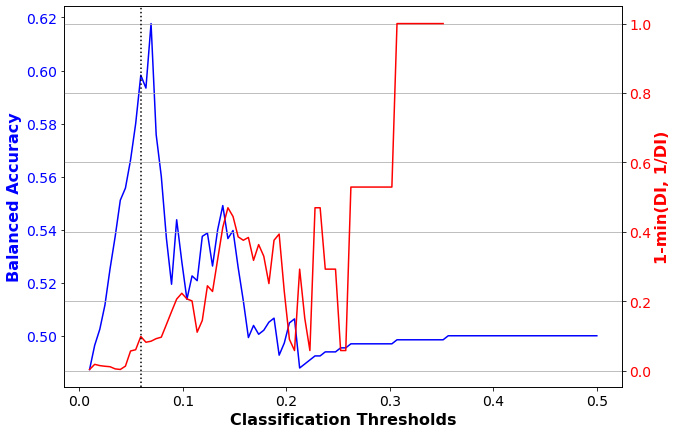

In [116]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

In [129]:
# 僅女性做婚姻狀態檢查
df_female = df[df['gender']=='female']
df_female = df_female.drop('gender', axis=1)
df_onehot = pd.concat([df[['found_job', 'age', 'loan', 'loan_status', 'military_status', 'aboriginal', 'nationality', 'english_level', 'bmi']], 
                        pd.get_dummies(df[['highest_education', 'highest_graduation', 'highest_school_level', 'marriage']])], axis=1)
df_onehot.head()

,found_job,age,loan,loan_status,military_status,aboriginal,nationality,english_level,bmi,highest_education_B,...,highest_graduation_Y,highest_school_level_1,highest_school_level_2,highest_school_level_3,highest_school_level_4,highest_school_level_5,highest_school_level_6,highest_school_level_7,marriage_N,marriage_Y
0,0,24,0,1,1,0,1,2.0,22.9,1,...,1,0,0,1,0,0,0,0,1,0
1,0,28,1,1,1,0,1,2.0,20.8,1,...,1,0,1,0,0,0,0,0,1,0
2,0,24,1,1,1,0,1,2.0,26.0,1,...,1,0,0,1,0,0,0,0,1,0
3,0,21,0,1,1,0,1,2.0,17.7,1,...,1,0,0,0,0,1,0,0,1,0
4,0,22,0,1,1,0,1,3.0,18.7,1,...,0,0,0,0,0,0,1,0,1,0


In [149]:
df_aif = BinaryLabelDataset(df=df_onehot.drop('marriage_N', axis=1), label_names=['found_job'], protected_attribute_names=['marriage_Y'])

In [150]:
privileged_group = [{'marriage_Y': 0}]
unprivileged_group = [{'marriage_Y': 1}]

In [151]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(594, 22), (356, 22), (238, 22)]


In [152]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.428


In [153]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

In [154]:
thresh_arr = np.linspace(0.01, 0.5, 100)

In [155]:
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)

In [156]:
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

100%|██████████| 100/100 [00:00<00:00, 1411.64it/s]


In [157]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.059
Best balanced accuracy: 0.528
1-min(DI, 1/DI): 0.558


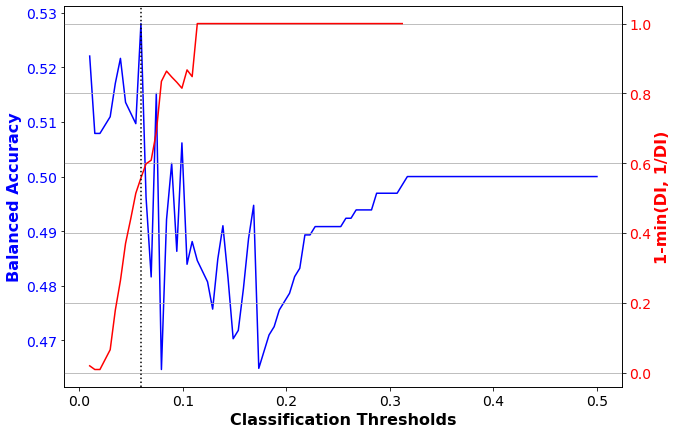

In [158]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

In [159]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)

dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

In [160]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.059
Best balanced accuracy: 0.544
1-min(DI, 1/DI): 0.657


In [142]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

In [143]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3)) 

1-min(DI, 1/DI): 0.0


In [144]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [145]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)

In [146]:
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

100%|██████████| 100/100 [00:00<00:00, 1495.92it/s]


In [147]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.124
Best balanced accuracy: 0.591
1-min(DI, 1/DI): 0.29


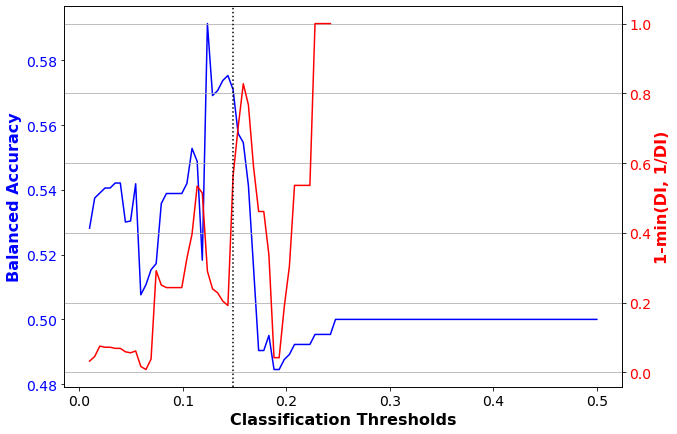

In [148]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))